In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# to output everything in a cell instead of only the last output

%matplotlib inline

# standard imports
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

## import data

In [2]:
SSH_train = np.expand_dims(np.load('trainAVISO-SSH_2000-2010.npy'),3)[:,25:168+25,280-200:,:] #you can use all the region, in here I selected a box of 168*168 size
SSH_test = np.expand_dims(np.load('testAVISO-SSH_2011.npy'),3)[:,25:168+25,280-200:,:] 
#######
Seg_train = np.expand_dims(np.load('trainSegmentation_2000-2010.npy'),3)[:,25:168+25,280-200:,:]
Seg_test = np.expand_dims(np.load('testSegmentation_2011.npy'),3)[:,25:168+25,280-200:,:]
######
SSH_train.shape
SSH_test.shape
#####
Seg_train.shape
Seg_test.shape

(4018, 168, 200, 1)

(365, 168, 200, 1)

(4018, 168, 200, 1)

(365, 168, 200, 1)

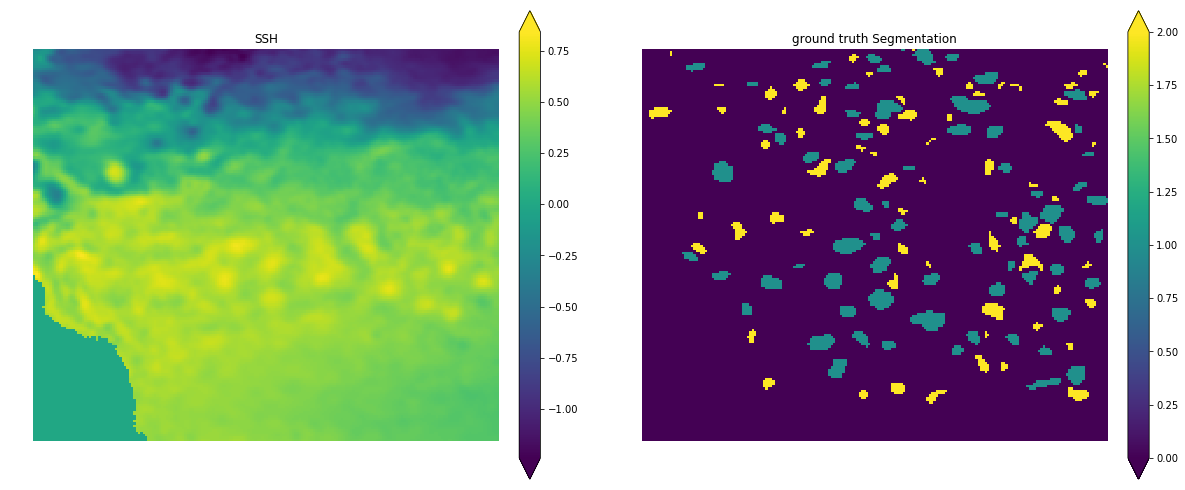

In [3]:
randindex=np.random.randint(0,len(SSH_train))

plt.figure(figsize=(20, 10))

plt.subplot(121)
plt.imshow(SSH_train[randindex,:,:,0], cmap='viridis')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.25,0.25)
plt.axis('off')
plt.title('SSH');

plt.subplot(122)
plt.imshow(Seg_train[randindex,:,:,0], cmap='viridis')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.25,0.25)
plt.axis('off')
plt.title('ground truth Segmentation');

## EddyResNet 

This architecture is based on combining Unet and Residual units, here we show a small EddyResNet

In [4]:
from keras.models import Model, load_model
from keras.layers import Activation, Reshape, Permute, Lambda
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, AlphaDropout, concatenate, Conv2DTranspose
from keras.layers import BatchNormalization, LeakyReLU, add
from keras.utils import np_utils
from keras.optimizers import Adam
from keras import backend as K
from keras import regularizers
import matplotlib.pyplot as plt
import numpy as np
import pickle
from IPython.display import SVG 
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

/home/lguensar/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
Seg_train_categor = np_utils.to_categorical(np.reshape(Seg_train[:,:,:,0],(4018,168*200)),3)
Seg_train_categor.shape

(4018, 33600, 3)

In [6]:
def FirstResUnit(nf,ker,inputs):
    conv1 = Conv2D(nf, ker, padding="same", kernel_initializer='he_normal', use_bias=False)(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv2 = Conv2D(nf, ker, padding="same", kernel_initializer='he_normal', use_bias=False)(conv1)
    return add([conv2,inputs])

def ResUnit(nf,ker,inputs, drop=0.5):
    conv1 = BatchNormalization()(inputs)
    conv1 = Activation('relu')(conv1)
    conv1 = Dropout(drop)(conv1)
    conv2 = Conv2D(nf, ker, padding="same", kernel_initializer='he_normal', use_bias=False)(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Dropout(drop)(conv2)
    conv2 = Conv2D(nf, ker, padding="same", kernel_initializer='he_normal', use_bias=False)(conv2)
    return add([conv2,inputs])

def ResUnitDecoder(nf,ker,inputs,drop=0.5):
    conv1 = BatchNormalization()(inputs)
    conv1 = Activation('relu')(conv1)
    conv1 = Dropout(drop)(conv1)
    conv2 = Conv2D(nf, ker, padding="same", kernel_initializer='he_normal', use_bias=False)(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Dropout(drop)(conv2)
    conv2 = Conv2D(nf, ker, padding="same", kernel_initializer='he_normal', use_bias=False)(conv2)
    ###
    shortcut = Conv2D(nf, 1, padding="same", kernel_initializer='he_normal', use_bias=False)(inputs)
    return add([conv2,shortcut])

In [7]:
width = 200
height = 168
nbClass = 3
nf = 32
ker = 3

###################################### INPUT LAYER

img_input = Input(shape=(height, width, 1))
######################################ENCODER

conv1 = FirstResUnit(nf,ker,img_input)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = ResUnit(nf,ker,pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

#######################################center

convC = ResUnit(nf,ker,pool2)

#######################################DECODER

up2 = concatenate([UpSampling2D((2,2))(convC), conv2])
decod2 = ResUnitDecoder(nf,ker,up2)

up1 = concatenate([UpSampling2D((2,2))(decod2), conv1])
decod1 = ResUnitDecoder(nf,ker,up1)

####################################### Segmentation Layer

x = Conv2D(nbClass, (1, 1), padding="valid", use_bias=False)(decod1) 
x = Reshape((height * width, nbClass))(x) 
x = Activation("softmax")(x)
eddynet = Model(img_input, x)

eddynet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 168, 200, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 168, 200, 32) 288         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 168, 200, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 168, 200, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

### calculate weights (some heavy data imbalance out there...)

In [8]:
unique, counts = np.unique(Seg_train, return_counts=True)
dict(zip(unique, counts))

{0: 120619130, 1: 9064601, 2: 5321069}

In [9]:
freq = [np.sum(counts)/j for j in counts]
weightsSeg = [f/np.sum(freq) for f in freq]
weightsSeg

[0.02704542813591602, 0.35988302322757637, 0.6130715486365075]

## loss functions

In [10]:
smooth = 1.  # to avoid zero division

def dice_coef_anti(y_true, y_pred):
    y_true_anti = y_true[:,:,1]
    y_pred_anti = y_pred[:,:,1]
    intersection_anti = K.sum(y_true_anti * y_pred_anti)
    return (2 * intersection_anti + smooth) / (K.sum(y_true_anti)+ K.sum(y_pred_anti) + smooth)

def dice_coef_cyc(y_true, y_pred):
    y_true_cyc = y_true[:,:,2]
    y_pred_cyc = y_pred[:,:,2]
    intersection_cyc = K.sum(y_true_cyc * y_pred_cyc)
    return (2 * intersection_cyc + smooth) / (K.sum(y_true_cyc) + K.sum(y_pred_cyc) + smooth)

def dice_coef_nn(y_true, y_pred):
    y_true_nn = y_true[:,:,0]
    y_pred_nn = y_pred[:,:,0]
    intersection_nn = K.sum(y_true_nn * y_pred_nn)
    return (2 * intersection_nn + smooth) / (K.sum(y_true_nn) + K.sum(y_pred_nn) + smooth)
    
def mean_dice_coef(y_true, y_pred):
    return (dice_coef_anti(y_true, y_pred) + dice_coef_cyc(y_true, y_pred) + dice_coef_nn(y_true, y_pred))/3.

def weighted_mean_dice_coef(y_true, y_pred):
    return (0.35*dice_coef_anti(y_true, y_pred) + 0.62*dice_coef_cyc(y_true, y_pred) + 0.03*dice_coef_nn(y_true, y_pred))
  
def dice_coef_loss(y_true, y_pred):
    return 1 - weighted_mean_dice_coef(y_true, y_pred)

In [11]:
eddynet.compile(optimizer=Adam(lr=1e-3), loss=dice_coef_loss,
                metrics=['categorical_accuracy', mean_dice_coef, weighted_mean_dice_coef])

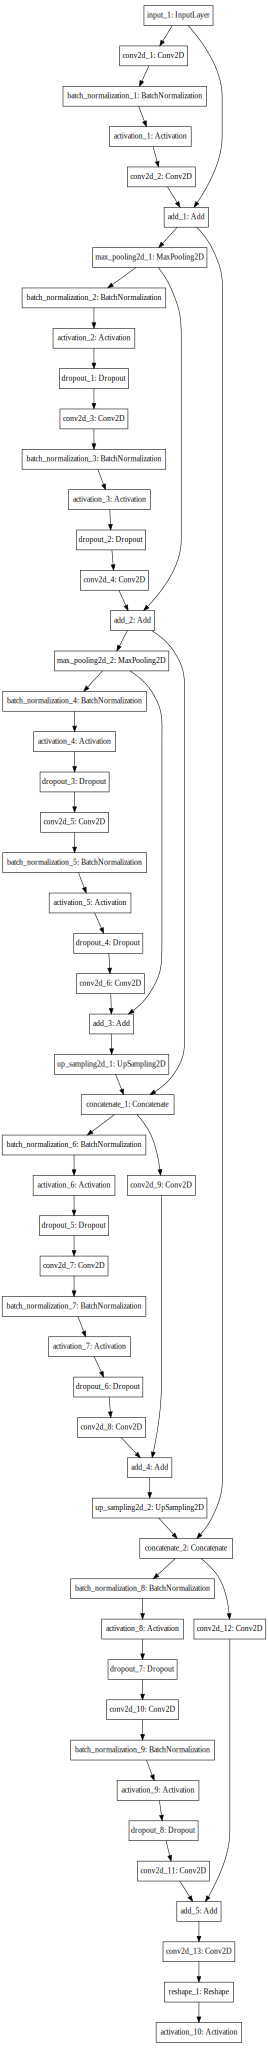

In [12]:
SVG(model_to_dot(eddynet).create(prog='dot', format='svg'))

## Training

In [13]:
earl = EarlyStopping(monitor='val_loss', min_delta=1e-8, patience=50, verbose=1, mode='auto')
modelcheck = ModelCheckpoint('./weights/eddyRESnet.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
reducecall = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, verbose=1, mode='auto', min_delta=1e-30, min_lr=1e-30)


histeddynet=eddynet.fit(SSH_train, Seg_train_categor,
                              epochs=5000,
                              batch_size=16,
                              shuffle=True,
                              verbose=1,
                              callbacks=[modelcheck,reducecall, earl],
                              validation_split=0.2
                              )

Train on 3214 samples, validate on 804 samples
Epoch 1/5000
3214/3214 [==============================] - 24s 7ms/step - loss: 0.5471 - categorical_accuracy: 0.8469 - mean_dice_coef: 0.5963 - weighted_mean_dice_coef: 0.4529 - val_loss: 0.5038 - val_categorical_accuracy: 0.8105 - val_mean_dice_coef: 0.6151 - val_weighted_mean_dice_coef: 0.4962

Epoch 00001: val_loss improved from inf to 0.50384, saving model to ./weights/eddyRESnet.h5
Epoch 2/5000
3214/3214 [==============================] - 20s 6ms/step - loss: 0.4768 - categorical_accuracy: 0.8868 - mean_dice_coef: 0.6549 - weighted_mean_dice_coef: 0.5232 - val_loss: 0.4827 - val_categorical_accuracy: 0.8252 - val_mean_dice_coef: 0.6319 - val_weighted_mean_dice_coef: 0.5173

Epoch 00002: val_loss improved from 0.50384 to 0.48274, saving model to ./weights/eddyRESnet.h5
Epoch 3/5000
3214/3214 [==============================] - 20s 6ms/step - loss: 0.4619 - categorical_accuracy: 0.8916 - mean_dice_coef: 0.6658 - weighted_mean_dice_coef: 


Epoch 00044: val_loss did not improve from 0.39465
Epoch 45/5000
3214/3214 [==============================] - 20s 6ms/step - loss: 0.3947 - categorical_accuracy: 0.9112 - mean_dice_coef: 0.7148 - weighted_mean_dice_coef: 0.6053 - val_loss: 0.4039 - val_categorical_accuracy: 0.8883 - val_mean_dice_coef: 0.7027 - val_weighted_mean_dice_coef: 0.5961

Epoch 00045: val_loss did not improve from 0.39465
Epoch 46/5000
3214/3214 [==============================] - 20s 6ms/step - loss: 0.3947 - categorical_accuracy: 0.9114 - mean_dice_coef: 0.7150 - weighted_mean_dice_coef: 0.6053 - val_loss: 0.3961 - val_categorical_accuracy: 0.8983 - val_mean_dice_coef: 0.7104 - val_weighted_mean_dice_coef: 0.6039

Epoch 00046: val_loss did not improve from 0.39465
Epoch 47/5000
3214/3214 [==============================] - 21s 6ms/step - loss: 0.3939 - categorical_accuracy: 0.9116 - mean_dice_coef: 0.7155 - weighted_mean_dice_coef: 0.6061 - val_loss: 0.3977 - val_categorical_accuracy: 0.8953 - val_mean_dice_c


Epoch 00067: val_loss did not improve from 0.39259
Epoch 68/5000
3214/3214 [==============================] - 20s 6ms/step - loss: 0.3868 - categorical_accuracy: 0.9134 - mean_dice_coef: 0.7206 - weighted_mean_dice_coef: 0.6132 - val_loss: 0.3951 - val_categorical_accuracy: 0.8960 - val_mean_dice_coef: 0.7110 - val_weighted_mean_dice_coef: 0.6049

Epoch 00068: val_loss did not improve from 0.39259
Epoch 69/5000
3214/3214 [==============================] - 20s 6ms/step - loss: 0.3865 - categorical_accuracy: 0.9135 - mean_dice_coef: 0.7208 - weighted_mean_dice_coef: 0.6135 - val_loss: 0.3983 - val_categorical_accuracy: 0.8924 - val_mean_dice_coef: 0.7075 - val_weighted_mean_dice_coef: 0.6017

Epoch 00069: val_loss did not improve from 0.39259
Epoch 70/5000
3214/3214 [==============================] - 20s 6ms/step - loss: 0.3864 - categorical_accuracy: 0.9136 - mean_dice_coef: 0.7208 - weighted_mean_dice_coef: 0.6136 - val_loss: 0.3987 - val_categorical_accuracy: 0.8915 - val_mean_dice_c


Epoch 00090: val_loss did not improve from 0.39095
Epoch 91/5000
3214/3214 [==============================] - 21s 6ms/step - loss: 0.3822 - categorical_accuracy: 0.9144 - mean_dice_coef: 0.7238 - weighted_mean_dice_coef: 0.6178 - val_loss: 0.3949 - val_categorical_accuracy: 0.8947 - val_mean_dice_coef: 0.7106 - val_weighted_mean_dice_coef: 0.6051

Epoch 00091: val_loss did not improve from 0.39095
Epoch 92/5000
3214/3214 [==============================] - 20s 6ms/step - loss: 0.3821 - categorical_accuracy: 0.9148 - mean_dice_coef: 0.7240 - weighted_mean_dice_coef: 0.6179 - val_loss: 0.3934 - val_categorical_accuracy: 0.8978 - val_mean_dice_coef: 0.7127 - val_weighted_mean_dice_coef: 0.6066

Epoch 00092: val_loss did not improve from 0.39095
Epoch 93/5000
3214/3214 [==============================] - 20s 6ms/step - loss: 0.3825 - categorical_accuracy: 0.9145 - mean_dice_coef: 0.7237 - weighted_mean_dice_coef: 0.6175 - val_loss: 0.3938 - val_categorical_accuracy: 0.8960 - val_mean_dice_c

3214/3214 [==============================] - 20s 6ms/step - loss: 0.3786 - categorical_accuracy: 0.9153 - mean_dice_coef: 0.7263 - weighted_mean_dice_coef: 0.6214 - val_loss: 0.3917 - val_categorical_accuracy: 0.8990 - val_mean_dice_coef: 0.7141 - val_weighted_mean_dice_coef: 0.6083

Epoch 00137: val_loss did not improve from 0.38996
Epoch 138/5000
3214/3214 [==============================] - 20s 6ms/step - loss: 0.3785 - categorical_accuracy: 0.9154 - mean_dice_coef: 0.7264 - weighted_mean_dice_coef: 0.6215 - val_loss: 0.3919 - val_categorical_accuracy: 0.8991 - val_mean_dice_coef: 0.7140 - val_weighted_mean_dice_coef: 0.6081

Epoch 00138: val_loss did not improve from 0.38996
Epoch 139/5000
3214/3214 [==============================] - 20s 6ms/step - loss: 0.3787 - categorical_accuracy: 0.9155 - mean_dice_coef: 0.7263 - weighted_mean_dice_coef: 0.6213 - val_loss: 0.3933 - val_categorical_accuracy: 0.8967 - val_mean_dice_coef: 0.7123 - val_weighted_mean_dice_coef: 0.6067

Epoch 00139: 

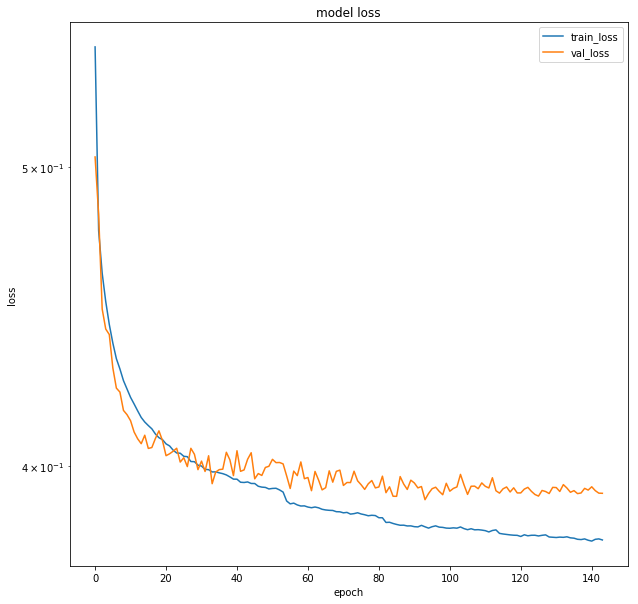

In [14]:
plt.figure(figsize=(10, 10))
plt.semilogy(eddynet.history.history['loss'])
plt.semilogy(eddynet.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper right');

## Performance on train dataset 
just to be sure...

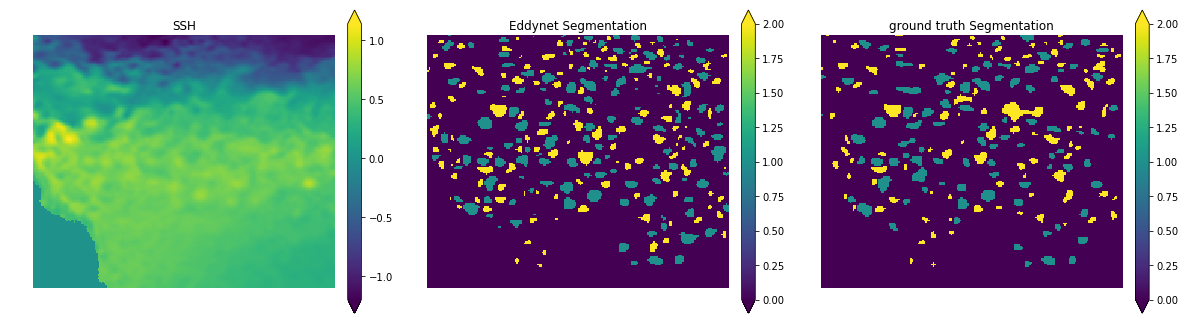

In [15]:
randindex=np.random.randint(0,len(SSH_train))
predictedSEGM=eddynet.predict(np.reshape(SSH_train[randindex,:,:],(1,height,width,1)))
predictedSEGMimage = np.reshape(predictedSEGM.argmax(2),(height,width))

plt.figure(figsize=(20, 10))

plt.subplot(131)
plt.imshow(SSH_train[randindex,:,:,0], cmap='viridis')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.25,0.25)
plt.axis('off')
plt.title('SSH');

plt.subplot(132)
plt.imshow(predictedSEGMimage, cmap='viridis')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.25,0.25)
plt.axis('off')
plt.title('Eddynet Segmentation');

plt.subplot(133)
plt.imshow(Seg_train[randindex,:,:,0], cmap='viridis')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.25,0.25)
plt.axis('off')
plt.title('ground truth Segmentation');

## Performance on test dataset (2011 data)

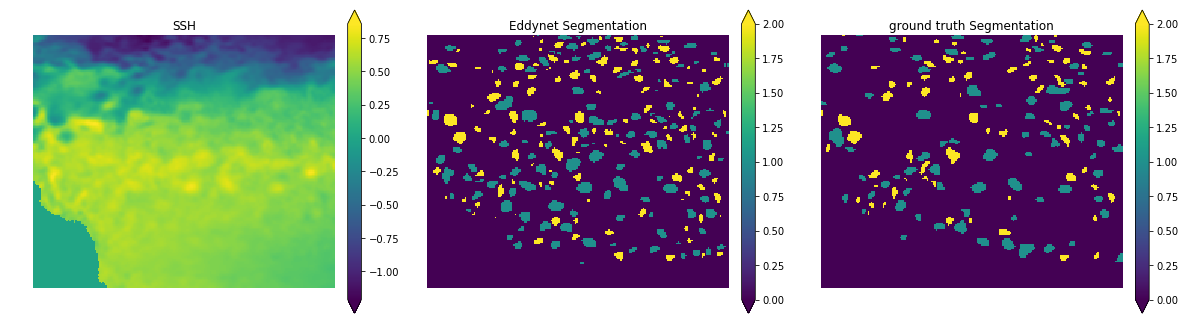

In [16]:
randindex=np.random.randint(0,len(SSH_test))
predictedSEGM=eddynet.predict(np.reshape(SSH_test[randindex,:,:],(1,height,width,1)))
predictedSEGMimage = np.reshape(predictedSEGM.argmax(2),(height,width))

plt.figure(figsize=(20, 10))

plt.subplot(131)
plt.imshow(SSH_test[randindex,:,:,0], cmap='viridis')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.25,0.25)
plt.axis('off')
plt.title('SSH');

plt.subplot(132)
plt.imshow(predictedSEGMimage, cmap='viridis')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.25,0.25)
plt.axis('off')
plt.title('Eddynet Segmentation');

plt.subplot(133)
plt.imshow(Seg_test[randindex,:,:,0], cmap='viridis')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.25,0.25)
plt.axis('off')
plt.title('ground truth Segmentation');

Seems working nicely, but there are some false eddy detections that need to be dealt with.

On my new paper I show that combining EddyResNet with ideas from level set segmentation leads to better results, I'll post the code upon acceptance of the paper

## metrics on test dataset

In [17]:
Seg_test_categor = np_utils.to_categorical(np.reshape(Seg_test[:,:,:,0],(365,168*200)),3)
Seg_test_categor.shape

(365, 33600, 3)

In [18]:
eddynet.evaluate(SSH_test,Seg_test_categor)

365/365 [==============================] - 1s 3ms/step


[0.3855386854851083,
 0.9019014943135928,
 0.7187079014843457,
 0.6144613145148917]

In [19]:
#### if you wanna use some animations ;) 


#imageList=[]
#for i in range(1200,1400):
#    imageList.append(SSH_train[i,:,:,0])
  

#print('drawing the animation...')
#from matplotlib import animation, rc
#from IPython.display import HTML

#def getImageFromList(x):
#    return imageList[x]

#fig = plt.figure(figsize=(10, 10))
#ims = []
#for i in range(len(imageList)):
#    im = plt.imshow(getImageFromList(i), animated=True, cmap='viridis')
#    ims.append([im])
#plt.axis('off')

#ani = animation.ArtistAnimation(fig, ims, interval=50, blit=False, repeat=False)
#plt.close()

#HTML(ani.to_jshtml())